# **Adding gene associations to reactions in the PlantCoreMetabolism 2.0 model (and similar generic models)**

##Step 1:  Install cobra and retrieve the PlantCoreMetabolism 2.0 model
*   Run `%pip install cobra` to install cobrapy
*   Use wget using the syntax `!wget link-to-file` to retrieve the models and functions required for this analysis

In [ ]:
%pip install cobra --quiet

!wget -q https://raw.githubusercontent.com/sshameer/DielLeafModeling/refs/heads/main/PlantCoreMetabolism_v2_0_0.xml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 19.1 MB/s eta 0:00:00


##Step 2: Import functions required to read sbml and check for genes
*   A cobra model can be generated from an SBML file using the` read_sbml_model`
function in the cobrapy io module

In [ ]:
import cobra

model = cobra.io.read_sbml_model('PlantCoreMetabolism_v2_0_0.xml')

In [ ]:
#checking genes in the model
model.genes

[]

 As a generic model of plant primary metabolism, PlantCoreMetabolism 2.0 does not have any gene-protein-reaction associations (see cell above).

## Step 3: identification of metabolites and reaction
* It however uses SBML `notes` and `annotation` elements to report information that help easy identification of metabolite and reaction objects (such as INCHI and EC numbers, respectively)

In [ ]:
print(model.metabolites[1].notes)
print(model.metabolites[1].annotation)

{'INCHI': 'InChI=1/C5H11NO2/c1-3(2)4(6)5(7)8/h3-4H,6H2,1-2H3,(H,7,8)/t4-/m0/s1/f/h6H', 'FORMULA': 'C5H11N1O2', 'CHARGE': '0'}
{'biocyc': 'META:VAL'}


In [ ]:
print(model.reactions[10].notes)
print(model.reactions[10].annotation)


{'SUBSYSTEM': 'xanthophyllcycle, antheraxanthinandviolaxanthinbiosynthesis', 'PROTEIN_CLASS': '1.14.13.90'}
{'ec-code': '1.14.13.90', 'biocyc': 'META:RXN-7978'}


##Step 4: Retrieve information on EC numbers and subcellular localizations of all Arabidopsis genes.

Information on gene annotations, functional annotation and protein subcellular localization for many organism can be found in organism specific databases such as TAIR (Arabidopsis), PlantCyc PGDBs, etc or general databases such as Uniprot, KEGG.  

Here, in order the permit the user to apply the approach for any plant species of interest, Uniprot is used for the demonstration. See query [here](https://www.uniprot.org/uniprotkb?query=*&facets=model_organism%3A3702). Results can be downloaded to TSV using the "Download" option (included in github repo for the ease of use).

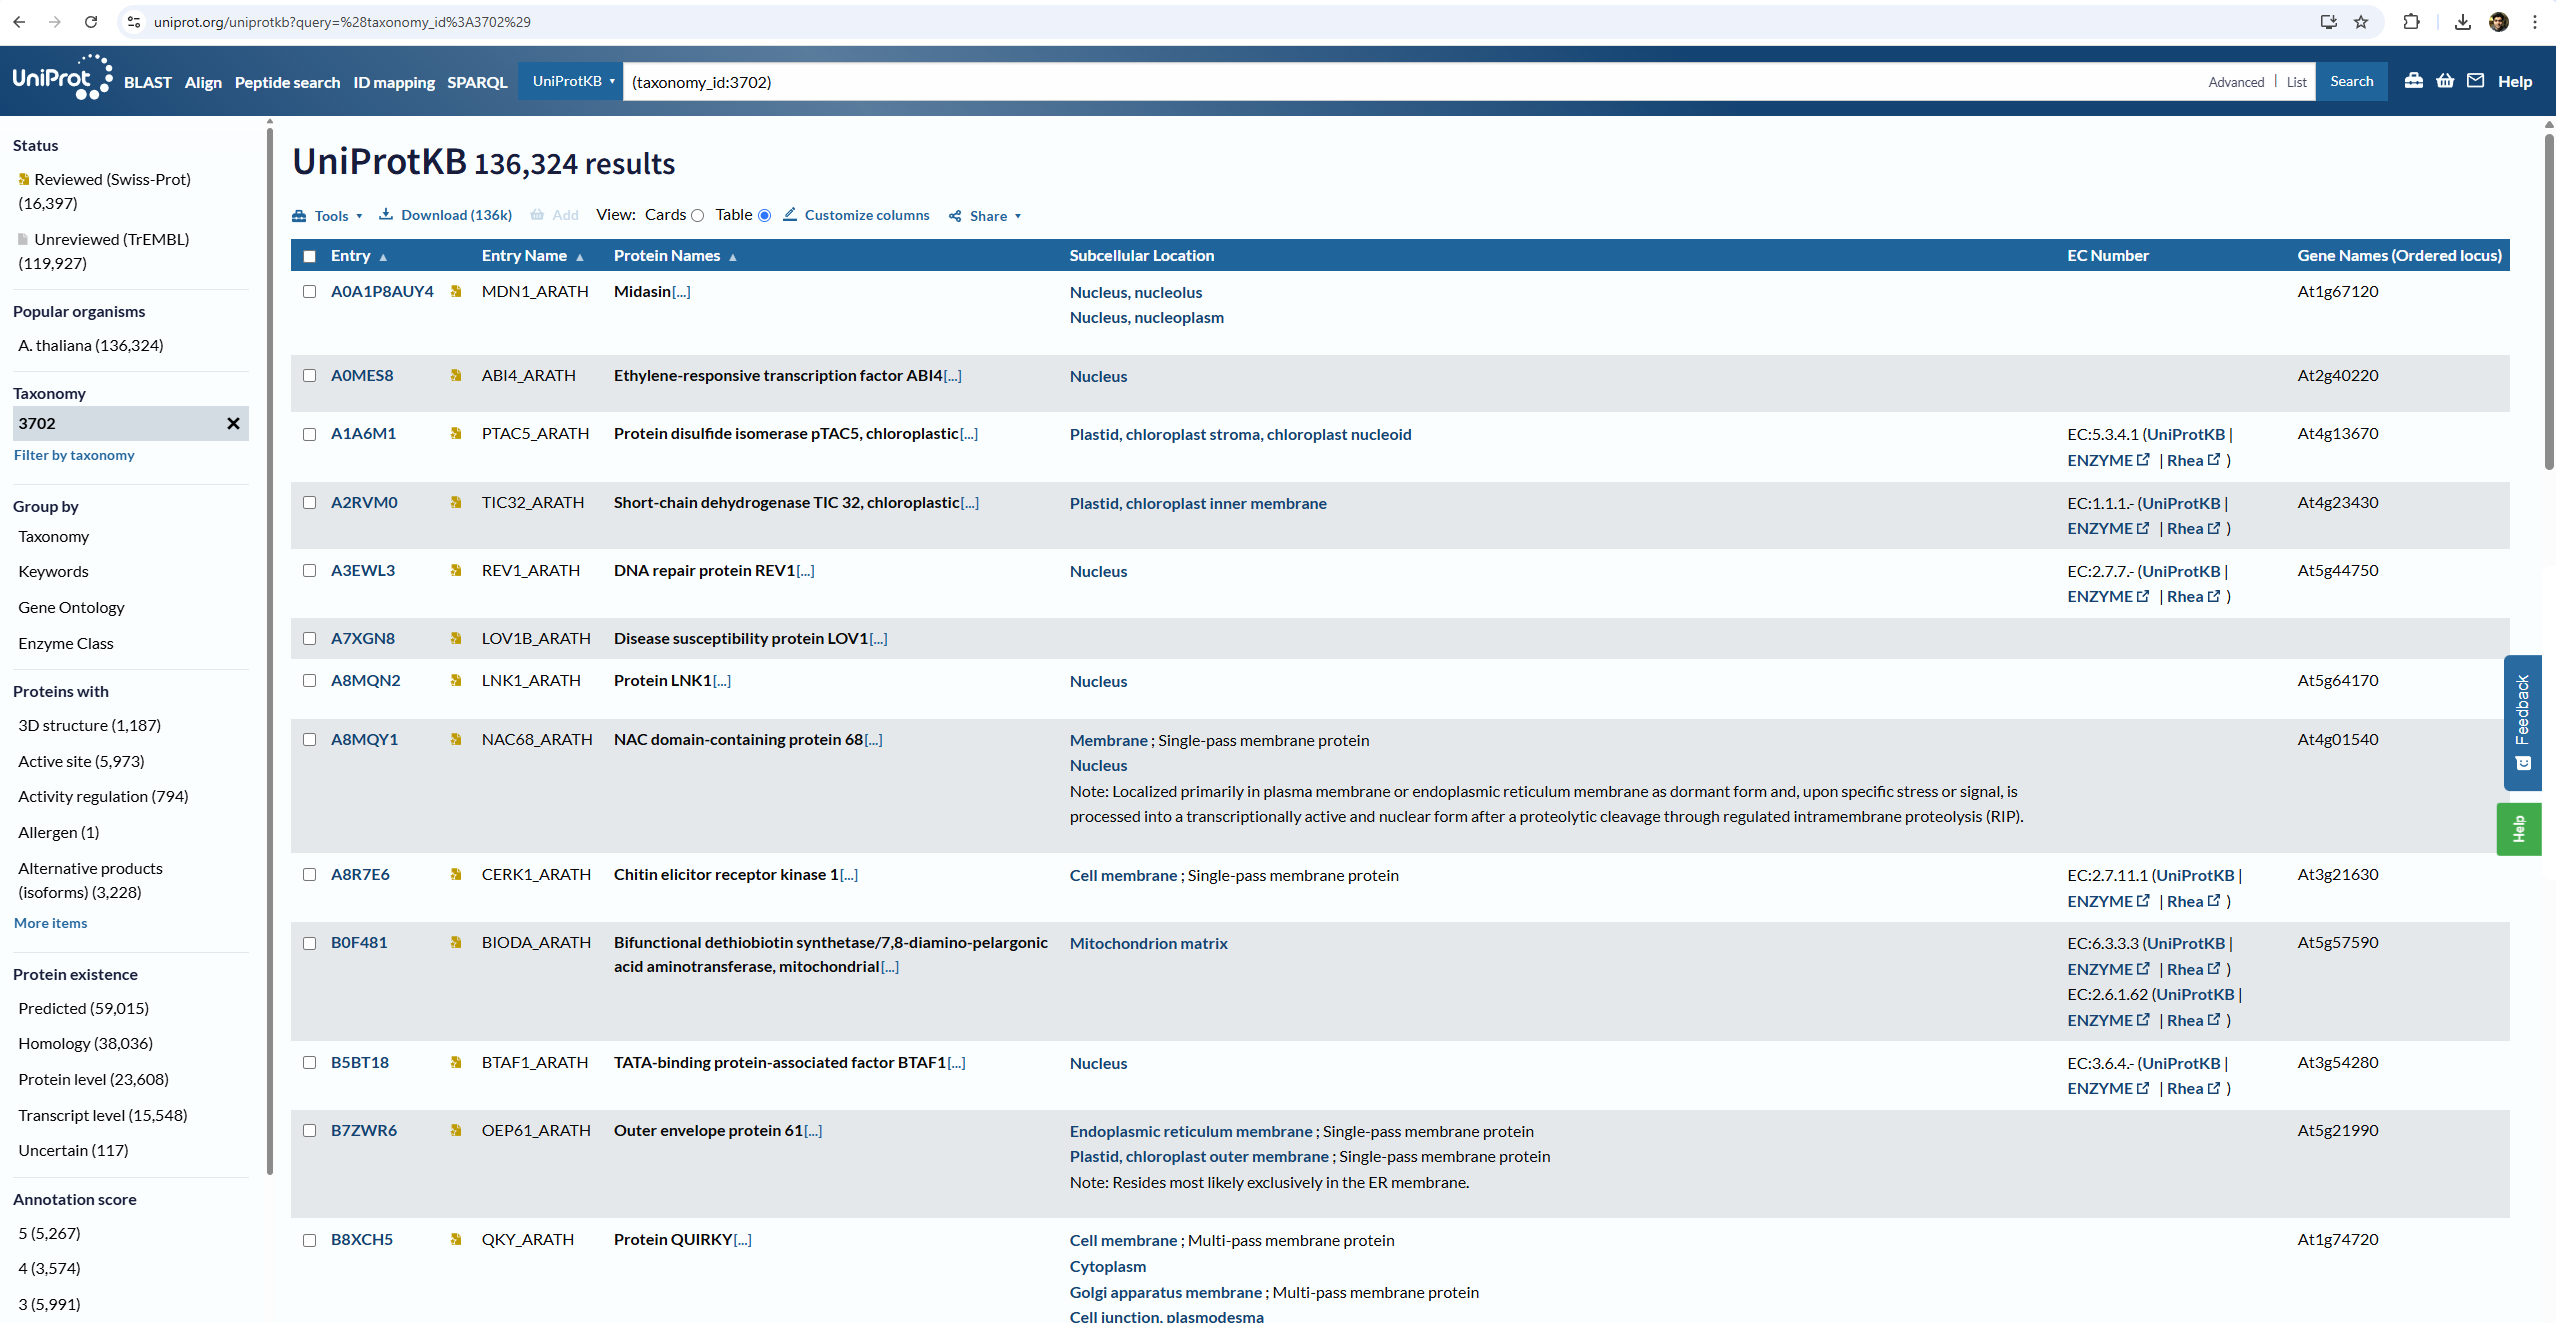

## Step 5: retrive the Gene-Protein-interaction from the repository

In [ ]:
!wget -q https://github.com/sshameer/DielLeafModeling/raw/refs/heads/main/uniprotkb_AND_model_organism_3702_2025_05_13.tsv

In [ ]:
import pandas as pd

df = pd.read_csv('uniprotkb_AND_model_organism_3702_2025_05_13.tsv', sep='\t')
df['Subcellular location [CC]'] = df['Subcellular location [CC]'].str.lower()
df.head()

,Entry,Reviewed,Entry Name,Protein names,Subcellular location [CC],EC number,Gene Names (ordered locus)
0,A0A0A7EPL0,reviewed,PIAL1_ARATH,E4 SUMO-protein ligase PIAL1 (EC 2.3.2.-) (Pro...,subcellular location: nucleus {eco:0000305}.,2.3.2.-,At1g08910
1,A0A178UEF6,unreviewed,A0A178UEF6_ARATH,Receptor-like serine/threonine-protein kinase ...,subcellular location: membrane {eco:0000256|ar...,2.7.11.1,AXX17_At5g23730
2,A0A178UFM8,unreviewed,A0A178UFM8_ARATH,non-specific serine/threonine protein kinase (...,subcellular location: membrane {eco:0000256|ar...,2.7.11.1,At5g51560 AXX17_At5g50380
3,A0A178UFS2,unreviewed,A0A178UFS2_ARATH,Serine/threonine-protein kinase RIO1 (EC 2.7.1...,subcellular location: cytoplasm {eco:0000256|a...,2.7.11.1,AXX17_At5g34420
4,A0A178UIP5,unreviewed,A0A178UIP5_ARATH,non-specific serine/threonine protein kinase (...,subcellular location: cell membrane {eco:00002...,2.7.11.1,AXX17_At5g39930


##Step 6: Appending the Gene-Protein-Interaction data into PlantCoreMetabolism model

In [ ]:
modelComp = model.compartments
modelComp["mi"] = 'Mitochondrion'
modelComp["mc"] = 'Mitochondrion'
modelComp["i"] = 'Mitochondrion'
modelComp["l"] = 'Thylakoid'

rxnGeneDict = dict()
for rxn in model.reactions:
  if "PROTEIN_CLASS" in rxn.notes:
    # print(rxn.id)
    # print(rxn.notes["PROTEIN_CLASS"])
    rxnComp = rxn.reactants[0].compartment
    # print(rxnComp)
    temp =df[df["EC number"]==rxn.notes["PROTEIN_CLASS"]]
    temp = temp.dropna(subset=["Subcellular location [CC]", "Gene Names (ordered locus)"])
    temp = temp[temp["Subcellular location [CC]"].str.contains(modelComp[rxnComp].lower())]
    genelist = list()
    for i,x in temp.iterrows():
      genelist.append(x["Gene Names (ordered locus)"].upper())

    if len(genelist)>0:
      rxnGeneDict[rxn.id]=genelist

for rxn in rxnGeneDict.keys():
  rxn = model.reactions.get_by_id(rxn)
  for gene in rxnGeneDict[rxn.id]:
    if rxn.gene_reaction_rule == "":
      rxn.gene_reaction_rule = "("+gene+")"
    else:
      rxn.gene_reaction_rule = rxn.gene_reaction_rule.replace(")"," or " + gene+")")

In [ ]:
len(model.genes)

224

In [ ]:
i = 0
for rxn in model.reactions:
  if rxn.gene_reaction_rule != "":
    i+=1
print(i)

310


Based on the data collected from Uniprot database, 224 Arabidopsis genes were added to 310 reactions in the model to transform the generic PlantCoreMetabolism model into a Arabidopsis model. Additional gene-protein-reaction associations can be added to the model by relying on alternative data sources (such as [TAIR](https://www.arabidopsis.org/) and [SUBA](https://suba.live/) Arabidopsis specific database), accounting for protein complexes and transporter proteins.